# 导入相关包

In [2]:
import sys
sys.path.append("../")
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from brain_block.random_initialize import connect_for_block, connect_for_multi_sparse_block
from brain_block.block import block
from analysis.spike_statistics import *
from scipy.ndimage import gaussian_filter1d
from scipy.io import loadmat
%matplotlib inline

# 小网络模拟主程序
## 仅仅考虑两个突触通道：$AMPA, \tau = 2 ms$ 和 $GABA_{A}, \tau=10 ms$

In [2]:
prob = torch.tensor([[1.]])
path = "small_block_100_two_channel"
tau_ui = (2, 40, 10, 50)

# AMPA: 0.02, GABA_A: 0.1 synchronize
specifcied_gui = np.array((0.01,
                         0.,
                         0.005,
                         0.)
                        )

# if os.path.exists(os.path.join(path, 'single', 'block_0.npz')):
#     print("remove")
#     os.remove(os.path.join(path, 'single', 'block_0.npz'))
# connect_for_multi_sparse_block(prob, {'g_Li': 0.03,
#                                       'g_ui': specifcied_gui,
#                                       "V_reset": -65,
#                                         'tao_ui': tau_ui},
#                                E_number=int(1.6e3), I_number=int(4e2), degree=500, init_min=1,
#                                init_max=1, perfix=path)
property, w_uij = connect_for_block(os.path.join(path, 'single'))

print("gui: ", specifcied_gui)
property[:, 10:14] = torch.tensor(specifcied_gui)

property = property.cuda()
w_uij = w_uij.cuda()
B = block(
    node_property=property,
    w_uij=w_uij,
    delta_t=0.1,
)
log_all = []
for time in range(20000):
    print(time, end='\r')
    B.run(noise_rate=0.0003, isolated=False)
    if time >= 10000:
        log_all.append(B.active.data.cpu().numpy())
log_all = np.array(log_all, dtype=np.uint8)
log = log_all[:, 1400:1650]
log = log.reshape((-1, 10, 250))
sub_log = log.sum(axis=1)
# np.save(os.path.join(self.path, "log.npy"), sub_log)
print("log.max", log.max())
fr = instantaneous_rate(sub_log, bin_width=5)
rate_time_series_auto_kernel = gaussian_filter1d(fr, 20, axis=-1)

fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_subplot(1, 1, 1, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_xlabel('time(ms)')
ax = fig.add_axes([0.1, 0.4, 0.8, 0.5])
x, y = sub_log[:, :200].nonzero()
ax.scatter(x, y, marker='.', color="black", s=1)
x, y = sub_log[:, 200:].nonzero()
ax.scatter(x, y + 200, marker='.', color="red", s=1)
ax.set_xlim([0, 1000])
ax.set_ylim([0, 250])
ax.set_xticks([])
ax.set_ylabel('neuron')
ax.invert_yaxis()
ax.set_aspect(1)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.2])
ax.plot(rate_time_series_auto_kernel, color='0.2')
ax.plot(fr, color='0.8')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylabel("fr(KHz)")
torch.cuda.empty_cache()

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'small_block_100_two_channel\\single'

# 单神经元的OU逼近分析
Orinignal model which has absorbed some complicated parameter
$ \tau_{j} \dot{V_{j}}  = - \sum_{A=L, E, I}g_{A}^{j}(V_{j} - E_{A})$
where $\dfrac{g_{E, I}^{j}}{g_{L}^{j}}=\tau_{j}\sum_{m} \sum_{k|t_{m}^{k}<t}\int_{-\infty}^{t}dt^{\prime}a_{\tau_{decay}}\left(t - t^{\prime}\right) \delta(t^{\prime}-t_{m}^{k})$, usually, $a_{\tau_{decay}}(t)=e^{-t / \tau_{decay}} / \tau_{decay}$, but here we use the limit that $\tau_{decay} \rightarrow 0$

* excitatory and inhibitory currents must be fine-tuned to produce an average input below threshold.
    * Specifically, if K and J represent the average number of input connections per neuron and synaptic efficacy, respectively, the difference between excitatory and inhibitory presynaptic inputs must be of the order of 1=KJ.
* input fluctuations should be large enough to drive firing.

Under the assumption, we can use the diffusion approximation and approximate the conductances as
\begin{equation}
\begin{aligned}
&\frac{g_{E}}{g_{L}}=a \tau_{L}\left[K r_{E}+\sqrt{K r_{E}} \zeta_{E}\right], \\
&\frac{g_{I}}{g_{L}}=a g \tau_{L}\left[\gamma K r_{I}+\sqrt{\gamma K r_{I}} \zeta_{I}\right]
\end{aligned}
\end{equation}

Using the diffusion approximation, OU process, the CV equation can be reduced to
\begin{equation}
\tau \frac{d V}{d t}=-V+\mu+\sigma(V) \sqrt{\tau} \zeta
\end{equation}
where
\begin{equation}
\begin{aligned}
\tau^{-1} &=\tau_{L}^{-1}+a K\left(r_{E}+r_{I} g \gamma\right) \\
\mu &=\tau\left\{E_{L} / \tau_{L}+a K\left[r_{E} E_{E}+r_{I} g \gamma E_{I}\right]\right\} \\
\sigma^{2}(V) &=a^{2} K \tau\left[r_{E}\left(V-E_{E}\right)^{2}+g^{2} \gamma r_{I}\left(V-E_{I}\right)^{2}\right]
\end{aligned}
\end{equation}

## 研究OU逼近中的$\mu$和$\sigma$关于synaptic efficacy $a$，weight ratio $g$ 和 degree $K$的依赖关系

In [6]:
myblue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
mygreen = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
myred = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
mypurple = (0.5058823529411764, 0.4470588235294118, 0.6980392156862745)
myyellow = (0.8, 0.7254901960784313, 0.4549019607843137)
myblue2 = (0.39215686274509803, 0.7098039215686275, 0.803921568627451)
myred2 = (1.0, 0.6235294117647059, 0.6039215686274509)

degree 100: equibrim mu: -65.78947368421053
degree 1000: equibrim mu: -53.65853658536585
degree 5000: equibrim mu: -50.82872928176795
degree 10000: equibrim mu: -50.42134831460673
degree 100 12.860010704043175
degree 1000 19.57542520752398
degree 5000 20.832857702742235
degree 10000 21.0076819511968


NameError: name 'mypurple' is not defined

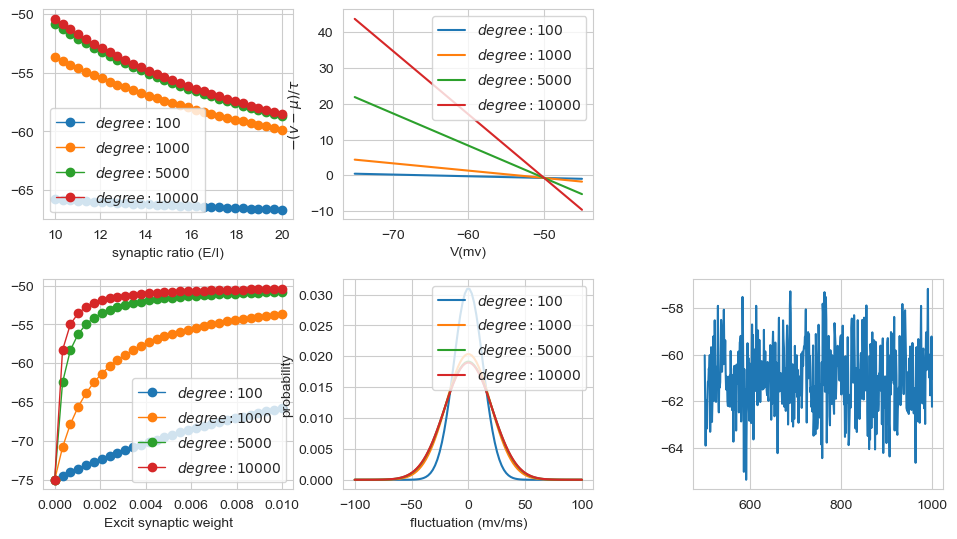

In [4]:

# default parameter
v_l = -75
v_th = -50
v_reset = -65
tau = 1 / 0.03
refractory = 5  # ms
E_E = 0
E_I = -70

def tau_efficient(a, g, k=80, r=0.005, gamma=0.25):
    r_E = r_I = r
    return 1 / (1 / tau + a * k * (r_E + r_I * g * gamma))

def mu(a, g, k=80, r=0.005, gamma=0.25):
    r_E = r_I = r
    return tau_efficient(a, g, k=k, r=r, gamma=gamma) * (v_l / tau + a * k * (r_E * E_E + r_I * g * gamma * E_I))

def sigma(a, g, k=80, r=0.005, gamma=0.25):
    r_E = r_I = r
    return a**2 * k * tau_efficient(a, g, k, r, gamma) * (r_E * (mu(a, g, k=80, r=0.005, gamma=0.25) -E_E) ** 2 + g**2 * gamma * r_I * (mu(a, g, k=80, r=0.005, gamma=0.25) - E_I) **2)
fig = plt.figure(figsize=(10, 6), dpi=100)
ax = []
ax1 = fig.add_axes([0.05, 0.1, 0.25, 0.35])
ax.append(ax1)
for k in np.array([100, 1000, 5000, 10000]):
    a_list = np.linspace(0., 0.01, 30)
    mu_lst = mu(a_list, 10., k)
    ax1.plot(a_list, mu_lst, marker="o", lw=1., linestyle="-", label="$degree:%d$"%k)
ax1.set_xlabel("Excit synaptic weight")
ax1.legend(loc="best")
ax2 = fig.add_axes([0.05, 0.55, 0.25, 0.35])
ax.append(ax2)
for k in np.array([100, 1000, 5000, 10000]):
    g_list = np.linspace(10, 20, 30)
    mu_lst = mu(0.01, g_list, k=k)
    ax2.plot(g_list, mu_lst, marker="o", lw=1.,  linestyle="-", label="$degree:%d$"%k)
ax2.set_xlabel("synaptic ratio (E/I)")
ax2.legend(loc="best")

ax3 = fig.add_axes([0.35, 0.55, 0.25, 0.35])
for degree in np.array([100, 1000, 5000, 10000]):
    v_list = np.linspace(-75, -45, 50)
    y_list = - (v_list - mu(0.01, 10, degree)) / tau_efficient(0.01, 10, degree)
    print(f"degree {degree}: equibrim mu: {mu(0.01, 10, degree)}")
    ax3.plot(v_list, y_list, label="$degree:%d$"%degree)
ax3.set_xlabel("V(mv)")
ax3.set_ylabel(r"$-(v-\mu) / \tau$")
ax3.legend(loc="best")
ax4 = fig.add_axes([0.35, 0.1, 0.25, 0.35])
def Gaussian(x, u, d):
    d_2 = d * d * 2
    zhishu = -(np.square(x - u) / d_2)
    exp = np.exp(zhishu)
    pi = np.pi
    xishu = 1 / (np.sqrt(2 * pi) * d)
    p = xishu * exp
    return p

x = np.linspace(-100, 100, 100)
u = 0
for degree in np.array([100, 1000, 5000, 10000]):
    scale = np.sqrt(sigma(0.01, 10, degree)) * np.sqrt(tau)
    print("degree", degree, scale)
    y = Gaussian(x, u, scale)
    ax4.plot(x, y, label="$degree:%d$"%degree)
ax4.set_xlabel("fluctuation (mv/ms)")
ax4.set_ylabel("probability")
ax4.legend(loc="best")

class OrnsteinUhlenbeck:
    def __init__(self, tau, mu, tmax, factor_B, dt, x0 = 0, seed=-1, up_L=-50, bottom_L=-75):
        self.up_L = up_L
        self.bottom_L = bottom_L
        self.dt = dt
        self.factor_B = factor_B
        self.tmax = tmax
        self.x0 = x0

        if seed!=-1:
            np.random.seed(seed)

        self.t = np.linspace(0,self.tmax,int(self.tmax/self.dt)+1)
        self.X = np.zeros((len(self.t),))
        self.X[0] = x0

        self.tau = tau
        self.mu = mu

    def simulate(self):
        for t in np.arange(1,len(self.t)):
            self.X[t] = self.X[t-1] + \
                          1 / self.tau*(self.mu-self.X[t-1]) * self.dt + \
                          self.factor_B / np.sqrt(self.tau) * np.random.randn(1)
            # ndcs_left  = np.nonzero(self.X[t,:]<self.bottom_L)[0]
            # ndcs_right = np.nonzero(self.X[t,:]>self.up_L)[0]
            # self.X[t,ndcs_left] += self.up_L - self.bottom_L
            # self.X[t,ndcs_right] -= self.up_L - self.bottom_L


    def get_trajectories(self):
        self.simulate()
        return self.t,self.X

ax5 = fig.add_axes([0.7, 0.1, 0.25, 0.35])
ax.append(ax5)
for a, g in [(0.004, 25), (0.008, 25)]:
    tau_here = tau_efficient(a, g, 5000)
    mu_here = mu(a, g, 5000)
    sigma_here = np.sqrt(sigma(a, g, 5000))
    ou_here = OrnsteinUhlenbeck(tau_here, mu_here, 1000, sigma_here, dt=1.)
    t , x = ou_here.get_trajectories()
    ax5.plot(t[-500:], x[-500:], label=f"$({a}, {g})$")
    ax5.plot(t[-500:], np.ones(500) * mu_here, color=mypurple, linestyle="--")
ax5.text(0.2, 0.9, "degree 5000", fontsize=12, transform=ax5.transAxes)
ax5.legend()
ax5.set_xlabel("time (ms)")
ax5.set_ylabel("v")


ax6 = fig.add_axes([0.7, 0.55, 0.25, 0.35])
ax.append(ax6)
for a, g in [(0.01, 5), (0.02, 5)]:
    tau_here = tau_efficient(a, g, 100)
    mu_here = mu(a, g, 100)
    sigma_here = np.sqrt(sigma(a, g, 100))
    ou_here = OrnsteinUhlenbeck(tau_here, mu_here, 1000, sigma_here, dt=1.)
    t , x = ou_here.get_trajectories()
    ax6.plot(t[-500:], x[-500:], label=f"$({a}, {g})$")
    ax6.plot(t[-500:], np.ones(500) * mu_here, color=mypurple, linestyle="--")
ax6.text(0.2, 0.9, "degree 100", fontsize=12, transform=ax6.transAxes)
# ax6.set_ylim([-65, -50])
ax6.legend()
ax6.set_xlabel("time (ms)")
ax6.set_ylabel("v")

for i in range(4):
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')
    ax[i].set_ylabel("$\mu$")

# 重写锁定发放率的约束方程
有理有据，得到新的二维流形约束
度100的情况下，{使兴奋性突触后电位大约为1.8mV,则抑制性后电位约为1.13mV,突触后电位为0.67mV(文献说在0.5-1mV)，突触电流约为0.51mV,合后电位为0.15mV,使发放不动点为10Hz}
\begin{equation}
\left\{
\begin{aligned}
&1g_{AMPA} + 5g_{NMDA} = 0.022 \\
&1g_{GABA_{A}}+ 18g_{GABA_{B}}=0.5
\end{aligned}
\right.
\end{equation}

## Standard deviation of Synaptic drive, using excitation as example


 efficacy:0.011, mean:34.320, sigma:0.145
 efficacy:0.014, mean:32.340, sigma:0.169
 efficacy:0.017, mean:30.360, sigma:0.193


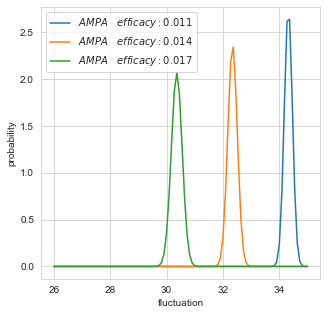

In [15]:
def Gaussian(x, u, d):
    d_2 = d * d * 2
    zhishu = -(np.square(x - u) / d_2)
    exp = np.exp(zhishu)
    pi = np.pi
    xishu = 1 / (np.sqrt(2 * pi) * d)
    p = xishu * exp
    return p

x = np.linspace(26, 35, 100)
u = 0
c1 = 0.022
a1 = 1
b1 = 5

fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
for efficacy1 in np.linspace(c1 / a1 / 2, c1/ a1 * 3 /4, 3):
    efficacy2 = (c1 - efficacy1 * a1) / b1
    scale = np.sqrt(3 * 80 / 2) * (efficacy1 + efficacy2)
    u = efficacy1 * 5 * 3 * 80 + efficacy2 * 40 * 3 * 80
    print(f" efficacy:{efficacy1:.3f}, mean:{u:.3f}, sigma:{scale:.3f}")
    y = Gaussian(x, u, scale)
    ax.plot(x, y, label="$AMPA \quad efficacy:%.3f$"%efficacy1)
ax.set_xlabel("fluctuation")
ax.set_ylabel("probability")
ax.legend(loc="best")

gabaA:0.013, E0:-61.785, sigma:42.362, tau:2.140
gabaA:0.132, E0:-60.894, sigma:27.390, tau:1.566
gabaA:0.250, E0:-60.380, sigma:22.415, tau:1.235
gabaA:0.000, E0:-61.924, sigma:45.372, tau:2.229
gabaA:0.013, E0:-61.783, sigma:42.328, tau:2.139
gabaA:0.026, E0:-61.654, sigma:39.682, tau:2.055
gabaA:0.039, E0:-61.534, sigma:37.372, tau:1.978
gabaA:0.053, E0:-61.422, sigma:35.350, tau:1.906
gabaA:0.066, E0:-61.319, sigma:33.574, tau:1.840
gabaA:0.079, E0:-61.222, sigma:32.012, tau:1.777
gabaA:0.092, E0:-61.132, sigma:30.634, tau:1.719
gabaA:0.105, E0:-61.048, sigma:29.417, tau:1.665
gabaA:0.118, E0:-60.968, sigma:28.339, tau:1.614
gabaA:0.132, E0:-60.894, sigma:27.384, tau:1.566
gabaA:0.145, E0:-60.823, sigma:26.538, tau:1.521
gabaA:0.158, E0:-60.757, sigma:25.786, tau:1.478
gabaA:0.171, E0:-60.694, sigma:25.118, tau:1.437
gabaA:0.184, E0:-60.635, sigma:24.524, tau:1.399
gabaA:0.197, E0:-60.579, sigma:23.997, tau:1.363
gabaA:0.211, E0:-60.525, sigma:23.528, tau:1.329
gabaA:0.224, E0:-60.

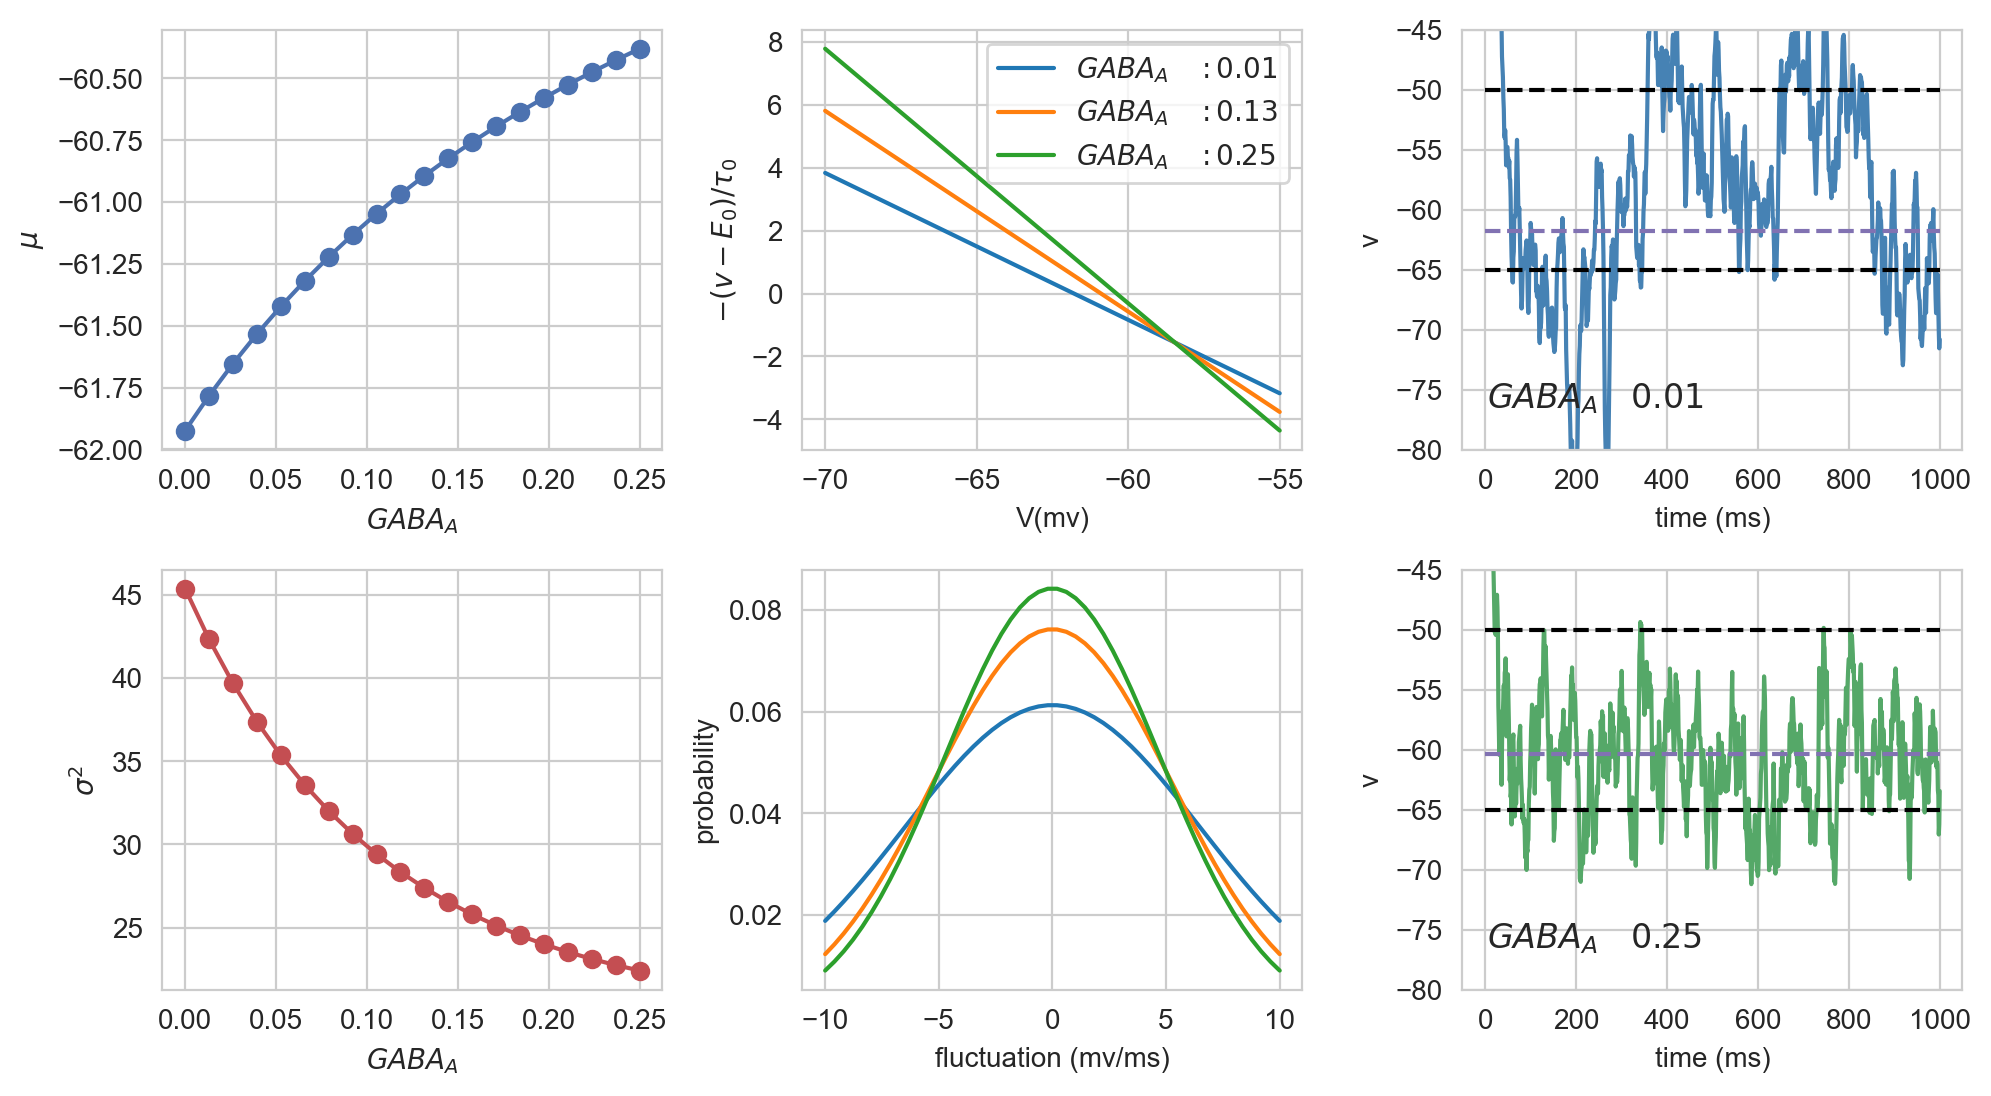

In [37]:
from analysis.brownian import *
tau = np.array([8, 40, 10, 50])
R = np.array([0.8, 0.8, 0.2, 0.2])
Ei = np.array([0, 0, -70, -100])
def Gaussian(x, u, d):
    d_2 = d * d * 2
    zhishu = -(np.square(x - u) / d_2)
    exp = np.exp(zhishu)
    pi = np.pi
    xishu = 1 / (np.sqrt(2 * pi) * d)
    p = xishu * exp
    return p


def g0(gl, *args):
    g1, g2, g3, g4= args * tau * R
    return gl + g1 + g2 + g3 + g4
def E0(gl, *args):
    g1, g2, g3, g4= args * tau * R
    g0_value = g0(gl, *args)
    return 1 / g0_value * (-70 * g3 -100 * g4)
def tau_0(gl, *args):
    go_value = g0(gl, *args)
    return 1 / go_value

def sigma(*args):
    sigma = 0
    g0_value = g0(0.03, *args)
    E0_value = E0(0.03, *args)
    sgima_A_all = []
    tau0 = tau_0(0.03, *args)
    for idx, efficacy in enumerate(args):
        g_A = efficacy * tau[idx] * R[idx]
        sigma_A = efficacy * np.sqrt(tau[idx]) * np.sqrt(R[idx] / 2)
        sgima_A_all.append(sigma_A)
        sigma_part = (sigma_A / g0_value)**2 * (Ei[idx] - E0_value)**2 * (tau[idx]) / (tau[idx] + tau0)
        sigma = sigma + sigma_part
    sigma = sigma + 2 * sgima_A_all[0] * sgima_A_all[1] / (g0_value ** 2) * (Ei[0] -E0_value) *(Ei[1] -E0_value) * np.sqrt(tau[0] * tau[1]) *(2 * tau[0] * tau[1] + tau[0]* tau0 + tau[1] * tau0) / ((tau[0]+tau[1]) *(tau[0] + tau0) * (tau[1] + tau0))
    sigma = sigma + 2 * sgima_A_all[2] * sgima_A_all[3] / (g0_value ** 2) * (Ei[2] -E0_value) *(Ei[3] -E0_value) * np.sqrt(tau[2] * tau[3]) *(2 * tau[2] * tau[3] + tau[2]* tau0 + tau[3] * tau0) / ((tau[2]+tau[3]) *(tau[2] + tau0) * (tau[3] + tau0))
    return sigma, E0_value, tau0

def correlated_input_output(rho=0.2, time=1000, *args):
    E0_value = E0(0.03, *args)
    g0_value = g0(0.03, *args)
    sigma_all= args * np.sqrt(tau / 2 * R)
    dw_e = get_corr_dW_matrix(time, 2, rho=rho)
    dw_i = get_corr_dW_matrix(time, 2, rho=rho)
    dw = np.concatenate([dw_e, dw_i], axis=1)
    ou_all1, ou_all2 = total_ou(tau, sigma_all, time, E0_value, dw)
    I_F = np.stack([ou_all1, ou_all2], axis=1)
    vout= lif_approx(E0_value, g0_value, I_F)
    return vout

def total_ou(tau_all, sigma_all, time, E0_value, dw):
    ou_all1 = np.zeros(time)
    ou_all2 = np.zeros(time)
    for i in range(4):
        ind1 = 0 if i<2 else 2
        ind2 = 1 if i<2 else 3
        ou_all1 += ou(tau_all[i], sigma_all[i], time, dw[:, ind1]) * (Ei[i] - E0_value)
        ou_all2 += ou(tau_all[i], sigma_all[i], time, dw[:, ind2])* (Ei[i] - E0_value)
    return ou_all1, ou_all2

def ou(tau, sigma, time, dw=None):
    if dw is None:
        dw = get_dW(time) * np.sqrt(tau)
    else:
        dw = dw * np.sqrt(tau)
    out0 = 1.
    out = []
    for i in range(time):
        out0 += -out0 / tau + np.sqrt(2) * sigma * dw[i] / tau
        out.append(out0)
    out = np.array(out)
    return out

def lif_approx(E0, g0, I_F:np.ndarray):
    v = np.ones(I_F.shape[1]) * (-60.)
    v_all = np.zeros_like(I_F)
    for i in range(len(I_F)):
        v = v - g0  * (v - E0) + I_F[i]
        v_all[i, :] = v
    return v_all


c1 = 0.022
a1 = 1
b1 = 5
c2 = 0.5
a2 = 1
b2 = 18


gabaA_all = np.linspace(0.013, c2 / a2 / 2, 3)
gabaB_all = (c2 - gabaA_all * a2) / b2
ampa, nmda = 0.01851899, 0.0006962
E0_all = []
sigma_all = []
tau0_all = []
for i in range(len(gabaA_all)):
    a, b, c = sigma(ampa, nmda, gabaA_all[i], gabaB_all[i])
    print(f"gabaA:{gabaA_all[i]:.3f}, E0:{b:.3f}, sigma:{a:.3f}, tau:{c:.3f}")
    sigma_all.append(a)
    E0_all.append(b)
    tau0_all.append(c)
sigma_all = np.array(sigma_all)
E0_all = np.array(E0_all)
tau0_all = np.array(tau0_all)

fig = plt.figure(figsize=(10, 6), dpi=200)
ax = []
ax1 = fig.add_axes([0.37, 0.55, 0.25, 0.35])
ax2 = fig.add_axes([0.37, 0.1, 0.25, 0.35])
ax.append(ax1)
ax.append(ax2)
x = np.linspace(-10, 10, 50)
for i in range(len(gabaA_all)):
    v_list = np.linspace(-70, -55, 50)
    y_list = -(v_list - E0_all[i]) / tau0_all[i]
    ax1.plot(v_list, y_list, label="$GABA_{A} \quad:%.2f$"%gabaA_all[i])
for i in range(len(gabaA_all)):
    y = Gaussian(x, 0, np.sqrt(sigma_all[i]))
    ax2.plot(x, y, label="$GABA_{A} \quad:%.2f$"%gabaA_all[i])
ax1.legend(loc="best")
ax1.set_xlabel("V(mv)")
ax1.set_ylabel(r"$-(v-E_{0}) / \tau_{0}$")
ax2.set_xlabel("fluctuation (mv/ms)")
ax2.set_ylabel("probability")

# ampa_all = np.linspace(c1 / a1 / 2, c1/ a1, 3)
# nmda_all = (c1 - ampa_all * a1) / b1
# gabaA, gabaB = 0.11075949, 0.02162447
# E0_all = []
# sigma_all = []
# tau0_all = []
# for i in range(len(ampa_all)):
#     a, b, c = sigma(ampa_all[i], nmda_all[i], gabaA, gabaA)
#     print(f"E0:{b:.3f}, sigma:{a:.3f}, tau:{c:.3f}")
#     sigma_all.append(a)
#     E0_all.append(b)
#     tau0_all.append(c)
# sigma_all = np.array(sigma_all)
# E0_all = np.array(E0_all)
# tau0_all = np.array(tau0_all)
# ax1 = fig.add_axes([0.55, 0.55, 0.4, 0.35])
# ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.35])
# ax.append(ax1)
# ax.append(ax2)
# x = np.linspace(-2, 2, 50)
# for i in range(len(ampa_all)):
#     v_list = np.linspace(-70, -50, 50)
#     y_list = -(v_list - E0_all[i]) / tau0_all[i]
#     ax1.plot(v_list, y_list, label="$AMPA \quad:%.2f$"%ampa_all[i])
# for i in range(len(ampa_all)):
#     y = Gaussian(x, 0, np.sqrt(sigma_all[i]))
#     ax2.plot(x, y, label="$AMPA \quad:%.2f$"%ampa_all[i])
# ax1.legend(loc="best")
# ax1.set_xlabel("V(mv)")
# ax1.set_ylabel(r"$-(v-\mu) / \tau$")
# ax2.set_xlabel("fluctuation (mv/ms)")
# ax2.set_ylabel("probability")

ax1 = fig.add_axes([0.05, 0.55, 0.25, 0.35])
ax2 = fig.add_axes([0.05, 0.1, 0.25, 0.35])
ax.append(ax1)
ax.append(ax2)
gabaA_all = np.linspace(0., c2 / a2 / 2, 20)
gabaB_all = (c2 - gabaA_all * a2) / b2
ampa, nmda = 0.01851899, 0.0006962
E0_all = []
sigma_all = []
for i in range(len(gabaA_all)):
    a, b, c = sigma(ampa, nmda, gabaA_all[i], gabaB_all[i])
    print(f"gabaA:{gabaA_all[i]:.3f}, E0:{b:.3f}, sigma:{a:.3f}, tau:{c:.3f}")
    sigma_all.append(a)
    E0_all.append(b)
sigma_all = np.array(sigma_all)
E0_all = np.array(E0_all)
ax1.plot(gabaA_all, E0_all, 'o-', color=myblue)
ax1.set_ylabel("$\mu$")
ax1.set_xlabel("$GABA_{A}$")
ax2.plot(gabaA_all, sigma_all, "o-", color=myred)
ax2.set_ylabel("$\sigma^{2}$")
ax2.set_xlabel("$GABA_{A}$")


gabaA_all = np.linspace(0.013, c2 / a2 / 2, 3)
gabaB_all = (c2 - gabaA_all * a2) / b2
ampa, nmda = 0.01851899, 0.0006962
E0_value = np.array([-61.785, -60.380])
Time =1000
vout = correlated_input_output(None, Time, ampa, nmda, gabaA_all[0], gabaB_all[0])
v_all = vout[:, 0]

ax1 = fig.add_axes([0.7, 0.55, 0.25, 0.35])
ax2 = fig.add_axes([0.7, 0.1, 0.25, 0.35])
ax.append(ax1)
ax.append(ax2)
ax1.plot(np.arange(Time), v_all, color='steelblue', lw=1.5)
ax1.plot(np.arange(Time), np.ones(Time) * E0_value[0], color=mypurple, linestyle="--")
ax1.plot(np.arange(Time), np.ones(Time) * -65, c="k", linestyle="--")
ax1.plot(np.arange(Time), np.ones(Time) * -50, c="k", linestyle="--")
ax1.set_ylim([-80, -45])
ax1.text(0.05, 0.1, "$GABA_{A}\quad 0.01$", fontsize=12, transform=ax1.transAxes)
ax1.set_xlabel("time (ms)")
ax1.set_ylabel("v")

vout = correlated_input_output(None, Time, ampa, nmda, gabaA_all[2], gabaB_all[2])
v_all = vout[:, 0]
ax2.plot(np.arange(Time), v_all, color=mygreen)
ax2.plot(np.arange(Time), np.ones(Time) * E0_value[1], color=mypurple, linestyle="--")
ax2.plot(np.arange(Time), np.ones(Time) * -65, c="k", linestyle="--")
ax2.plot(np.arange(Time), np.ones(Time) * -50, c="k", linestyle="--")
ax2.set_ylim([-80, -45])
ax2.text(0.05, 0.1, "$GABA_{A}\quad 0.25$", fontsize=12, transform=ax2.transAxes)
ax2.set_xlabel("time (ms)")
ax2.set_ylabel("v")

# for i in range(6):
#     ax[i].grid(False)
fig.savefig("../paper/fig/diffusion_theorem.png")

## 相关性的输入与相关的输出

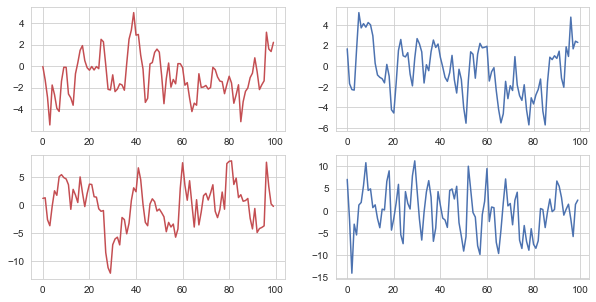

In [45]:
tau = np.array([8, 40, 10, 50])
R = np.array([0.8, 0.8, 0.2, 0.2])
Ei = np.array([0, 0, -70, -100])

# def lif_approx(E0, g0, I_F:np.ndarray):
#     v = np.ones(I_F.shape[1]) * (-60.)
#     v_all = np.zeros_like(I_F)
#     for i in range(len(I_F)):
#         v = v - g0  * (v - E0) + I_F[i]
#         spike = v>-50
#         v[np.where(spike)] = -65
#         v_all[i, :] = spike[0].astype(np.int8)
#     return v_all

def lif_approx(E0, g0, I_F:np.ndarray):
    v = np.ones(I_F.shape[1]) * (-60.)
    v_all = np.zeros_like(I_F)
    for i in range(len(I_F)):
        v = v - g0  * (v - E0) + I_F[i]
        v_all[i, :] = v
    return v_all

# gabaA_all = np.linspace(0.013, c2 / a2 / 2, 3)
# gabaB_all = (c2 - gabaA_all * a2) / b2
# ampa, nmda = 0.01851899, 0.0006962
# rho_list = np.linspace(-1, 1, 20)
# fig = plt.figure(figsize=(5, 5), dpi=200)
# for i in range(3):
#     p_all = np.zeros(20)
#     for j, rho in enumerate(rho_list):
#         vout = correlated_input_output(rho, 5000, ampa, nmda, gabaA_all[i], gabaB_all[i])
#         p = np.corrcoef(vout.T)[0, 1]
#         p_all[j] = p
#     fig.gca().plot(rho_list, p_all, "o--", lw=1.5, label="$GABA_{A} \quad:%.2f$"%gabaA_all[i])
# fig.gca().legend()
# fig.savefig("../paper/fig/correlate_input_output.png")

fig = plt.figure(figsize=(10, 5))
w_mat = get_corr_dW_matrix(100, 4, 0.3)
ou1 = ou(4, 2, 100, w_mat[:, 0])
ou2 = ou(3, 2, 100, w_mat[:, 1])
ou3 = ou(2.5, 3, 100, w_mat[:, 2])
ou4 = ou(1.5, 4, 100, w_mat[:, 3])
ax = fig.add_subplot(2, 2, 1)
ax.plot(ou1, color=myred)
ax = fig.add_subplot(2, 2, 2)
ax.plot(ou2, color=myblue)
ax = fig.add_subplot(2, 2, 3)
ax.plot(ou3, color=myred)
ax = fig.add_subplot(2, 2, 4)
ax.plot(ou4, color=myblue)
fig.savefig("../paper/fig/ou_diagram.eps")

### 初步模拟流形上几个参数点看看
### 确定流形的数学推导再定?

In [3]:
def index2param(param1, param2, num_grids, index):
    a1, b1, c1 = param1
    a2, b2, c2 = param2
    x, y = num_grids
    ampa = np.linspace(c1 / a1 / 2, c1/ a1, x)
    nmda = (c1 - ampa * a1) / b1
    gabaA = np.linspace(0., c2 / a2 / 2, y)
    gabaB = (c2 - gabaA * a2) / b2
    param = np.array([ampa[index[0]], nmda[index[0]], gabaA[index[1]], gabaB[index[1]]])
    return param

def plot2d(data, xrange, yrange, emphasise_range=None, name="fr"):
    if emphasise_range is None:
        raise ValueError
    else:
        fig= plt.figure(figsize=(8, 5), dpi=100)
        ax = []
        ax.append(fig.add_axes([0.05, 0.1, 0.35, 0.8]))
        ax.append(fig.add_axes([0.5, 0.1, 0.35, 0.8]))
        ax.append(fig.add_axes([0.9, 0.25, 0.02, 0.5]))
    x, y = data.shape
    im = ax[0].imshow(data)  # norm=norm
    data = np.where(np.logical_and(data<=emphasise_range[1], data>=emphasise_range[0]), data, np.nan)
    ax[1].imshow(data)
    fig.colorbar(im, ax=[ax[0], ax[1]], cax=ax[2])
    for i in range(2):
        ax[i].grid(False)
        yticks = np.linspace(0, x, 4, endpoint=False, dtype=np.int8)
        ax[i].set_yticks(yticks)
        ax[i].set_yticklabels([f'{data:.2f}' for data in yrange[yticks]], rotation=60)
        xticks = np.linspace(0, y, 4, endpoint=False, dtype=np.int8)
        ax[i].invert_yaxis()
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels([f'{data:.2f}' for data in xrange[xticks]], )
    ax[0].set_ylabel(r"$AMPA$")
    ax[0].set_xlabel(r"$GABA_{A}$")
    ax[0].set_title(name)

In [4]:
prob = torch.tensor([[1.]])

# d100
# tau_ui = (8, 40, 10, 50)
# specified_gui = index2param((1, 5, 0.022), (1, 18, 0.5), (80, 80), (50, 50))

# specified_gui = np.array([0.02000000000, 0.00043232323232323246, 0.16830848484848485, 0.018471969696969695])
# specified_gui = np.array([0.02000000000 / 8 * 3, 0.00043232323232323246, 0.16830848484848485, 0.018471969696969695])

# if os.path.exists(os.path.join(path, 'single', 'block_0.npz')):
#     print("remove")
#     os.remove(os.path.join(path, 'single', 'block_0.npz'))
# connect_for_multi_sparse_block(prob, {'g_Li': 0.03,
#                                       'g_ui': specified_gui,
#                                       "V_reset": -65,
#                                         'tao_ui': tau_ui},
#                                E_number=int(1.6e3), I_number=int(4e2), degree=100, init_min=0,
#                                init_max=1, perfix=path)
def simulation(specified_gui, path = "small_block_d100", ):
    print("specificed_gui", specified_gui)
    property, w_uij = connect_for_block(os.path.join(path, 'single'))

    property[:, 10:14] = torch.tensor(specified_gui)

    property = property.cuda()
    w_uij = w_uij.cuda()
    B = block(
        node_property=property,
        w_uij=w_uij,
        delta_t=0.1,
    )
    log_all = []
    for time in range(30000):
        print(time, end='\r')
        B.run(noise_rate=0.0003, isolated=False)
        if time >= 20000:
            log_all.append(B.active.data.cpu().numpy())
    log_all = np.array(log_all, dtype=np.uint8)
    log = log_all[:, 1400:1650]
    log = log.reshape((-1, 10, 250))
    sub_log = log.sum(axis=1)
    # sub_log = log
    # np.save(os.path.join(self.path, "log.npy"), sub_log)
    print("log.max", sub_log.max())
    pcc_log = pearson_cc(sub_log[:, :200], pairs=200)
    cc_log = correlation_coefficent(sub_log[:, :200])
    mean_fr = mean_firing_rate(sub_log[:, :200])
    print("mean_fr", mean_fr)
    print("cc: ", cc_log)
    print("pcc: ", pcc_log)
    fr = instantaneous_rate(sub_log, bin_width=5)
    rate_time_series_auto_kernel = gaussian_filter1d(fr, 20, axis=-1)
    fig = plt.figure(figsize=(10, 5), dpi=100)
    ax = fig.add_subplot(1, 1, 1, frameon=False)
    ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax.grid(False)
    ax.set_xlabel('time(ms)')
    ax = fig.add_axes([0.1, 0.35, 0.8, 0.5])
    ax.grid(False)
    x, y = sub_log[:, :200].nonzero()
    ax.scatter(x, y, marker='.', color="black", s=1)
    x, y = sub_log[:, 200:].nonzero()
    ax.scatter(x, y + 200, marker='.', color="red", s=1)
    ax.set_xlim([0, 1000])
    ax.set_ylim([0, 250])
    ax.set_xticks([])
    ax.set_ylabel('neuron')
    ax.invert_yaxis()
    ax.set_aspect(1)
    ax = fig.add_axes([0.1, 0.15, 0.8, 0.2])
    ax.grid(False)
    ax.plot(rate_time_series_auto_kernel, color='0.2')
    ax.set_xlim([0, 1000])
    ax.plot(fr, color='0.8')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_ylabel("fr(KHz)")
    torch.cuda.empty_cache()
    return fig


### 上述流形下的网格搜索结果

C:\Users\dell\AppData\Local\Temp\ipykernel_20108\3332214949.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax[0], shrink=0.6)
C:\Users\dell\AppData\Local\Temp\ipykernel_20108\3332214949.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax[1], shrink=0.6)
C:\Users\dell\AppData\Local\Temp\ipykernel_20108\3332214949.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax[3], shrink=0.6)
C:\Users\dell\AppData\Local\Temp\ipykernel_20108\3332214949.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor()

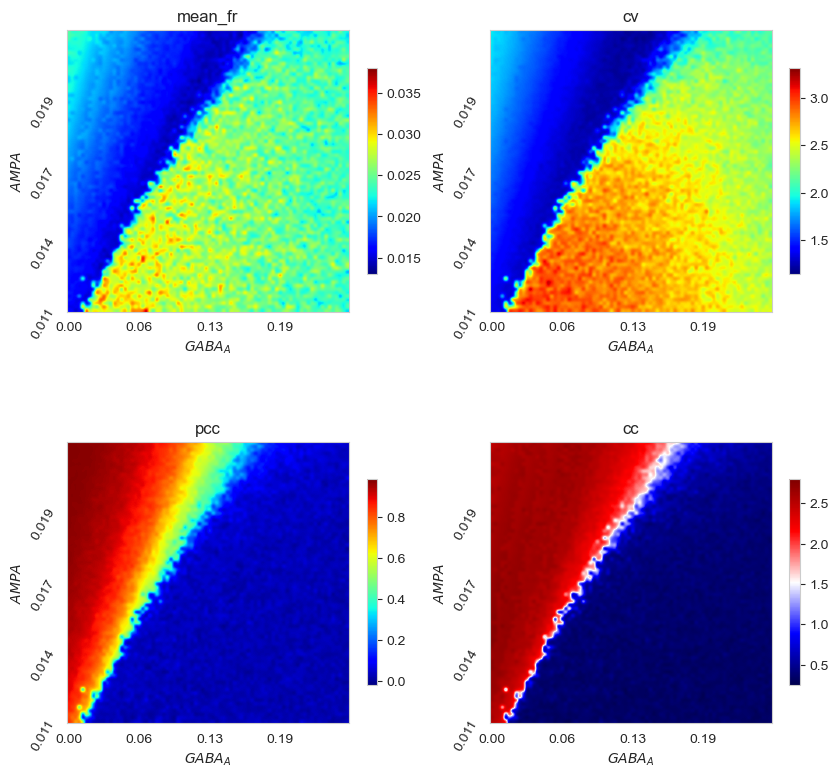

In [5]:
from matplotlib import colors
# file = np.load('../data/grid_search_d100_new.npz')
file = np.load('../data/grid_search_d100_new_new.npz')
# file = np.load('../data/grid_search_d500_new_new.npz')
mean_fr = file["mean_fr"]
cv = file["cv"]
pcc = file["pcc"]
ks = file["ks"]
cc = file["cc"]
ampa_contribution = file["ampa"]
gabaA_contribution = file["gabaA"]
fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=100)
ax = ax.flatten()
x, y = mean_fr.shape

im = ax[0].imshow(mean_fr, cmap='jet', interpolation='gaussian')
fig.colorbar(im, ax=ax[0], shrink=0.6)
ax[0].grid(False)
ax[0].set_title("mean_fr")

im = ax[1].imshow(cv, cmap='jet', interpolation='gaussian')
fig.colorbar(im, ax=ax[1], shrink=0.6)
ax[1].grid(False)
ax[1].set_title("cv")



def arg_percentile(series, x):
    a, b = 0, 1
    while True:
        # m是a、b的终点
        m = (a+b)/2
        # 可以打印查看求解过程
        # print(np.percentile(series, 100*m), x)
        if np.percentile(series, 100*m) >= x:
            b = m
        elif np.percentile(series, 100*m) < x:
            a = m
        # 如果区间左右端点足够靠近，则退出循环。
        if np.abs(a-b) <= 0.000001:
            break
    return m

cc_data = cc.flatten()
percent1 = arg_percentile(cc_data, 1.0)
percent2 = arg_percentile(cc_data, 1.5)
first = np.round(255*percent1).astype(np.int32)
second = np.round(255*(percent2 - percent1)).astype(np.int32)
third = 256 - first - second
#colors2 = new_cmap(np.linspace(0, 1, first))
colors1 = plt.cm.seismic(np.linspace(0.1, 0.42, first))
# colors2 = np.ones((second, 4), dtype=np.float64)
colors2 = plt.cm.seismic(np.linspace(0.42, 0.58, second))
colors3 = plt.cm.seismic(np.linspace(0.58, 0.9, third))
cols = np.vstack((colors1, colors2,colors3))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols)
im = ax[3].imshow(cc, interpolation='gaussian', cmap='seismic')
fig.colorbar(im, ax=ax[3], shrink=0.6)
ax[3].grid(False)
ax[3].set_title("cc")

im = ax[2].imshow(pcc, cmap='jet', interpolation='gaussian')
fig.colorbar(im, ax=ax[2], shrink=0.6)
ax[2].grid(False)
ax[2].set_title("pcc")


for i in range(4):
    yticks = np.linspace(0, x, 4, endpoint=False, dtype=np.int8)
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels([f'{data:.3f}' for data in ampa_contribution[yticks]], rotation=60)
    xticks = np.linspace(0, y, 4, endpoint=False, dtype=np.int8)
    ax[i].invert_yaxis()
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels([f'{data:.2f}' for data in gabaA_contribution[xticks]], )
    ax[i].set_ylabel(r"$AMPA$")
    ax[i].set_xlabel(r"$GABA_{A}$")
# fig.savefig("../paper/fig/phase_plot_d500.png")

### 检查子流形，分界线上的临界尺度信息

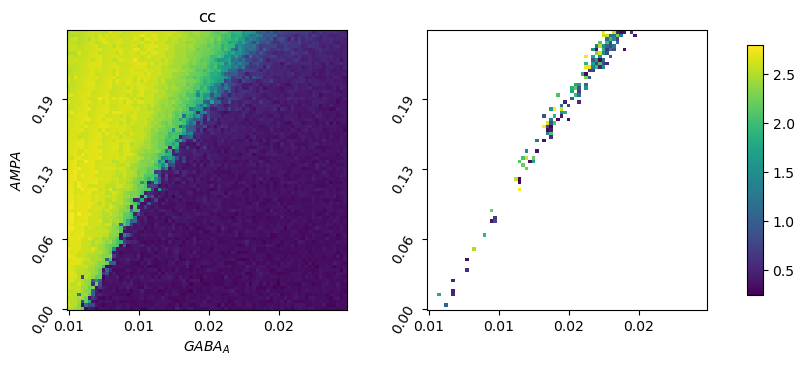

In [5]:
plot2d(cc, ampa_contribution, gabaA_contribution, emphasise_range=(1., 1.6), name="cc")

In [6]:
emphasise_range = (1., 1.6)
critical_index = np.where(np.logical_and(cc<=emphasise_range[1], cc>=emphasise_range[0]))
point = 40
print(critical_index[0][point], critical_index[1][point])
print("pcc", pcc[critical_index[0][point], critical_index[1][point]])
print("cc", cc[critical_index[0][point], critical_index[1][point]])
print("ks", ks[critical_index[0][point], critical_index[1][point]])
index = (critical_index[0][point], critical_index[1][point])
specified_gui = index2param((1, 5, 0.022), (1, 18, 0.5), (80, 80), (critical_index[0][point], critical_index[1][point]))
print("specified_gui:", specified_gui)
critical_param = []
for i in range(len(critical_index[0])):
    critical_param.append(index2param((1, 5, 0.022), (1, 18, 0.5), (80, 80), (critical_index[0][i], critical_index[1][i])))
# for i in range(80):
#     critical_param.append(index2param((1, 5, 0.022), (1, 18, 0.5), (80, 80), (60, i)))
#     critical_param.append(index2param((1, 5, 0.022), (1, 18, 0.5), (80, 80), (70, i)))
critical_param = np.stack(critical_param, axis=0)
# np.save("critical_param.npy", critical_param)


54 35
pcc 0.18917296988382795
cc 1.250685691833496
ks 0.06253513984884262
specified_gui: [0.01851899 0.0006962  0.11075949 0.02162447]


# 给DTB VERSION 1图一补充raster

torch.Size([2000, 22]) torch.Size([4, 2000, 2000])
log.max 1
mean_fr 0.008816326530612244
cc:  0.8012763
pcc:  0.07361747224190648


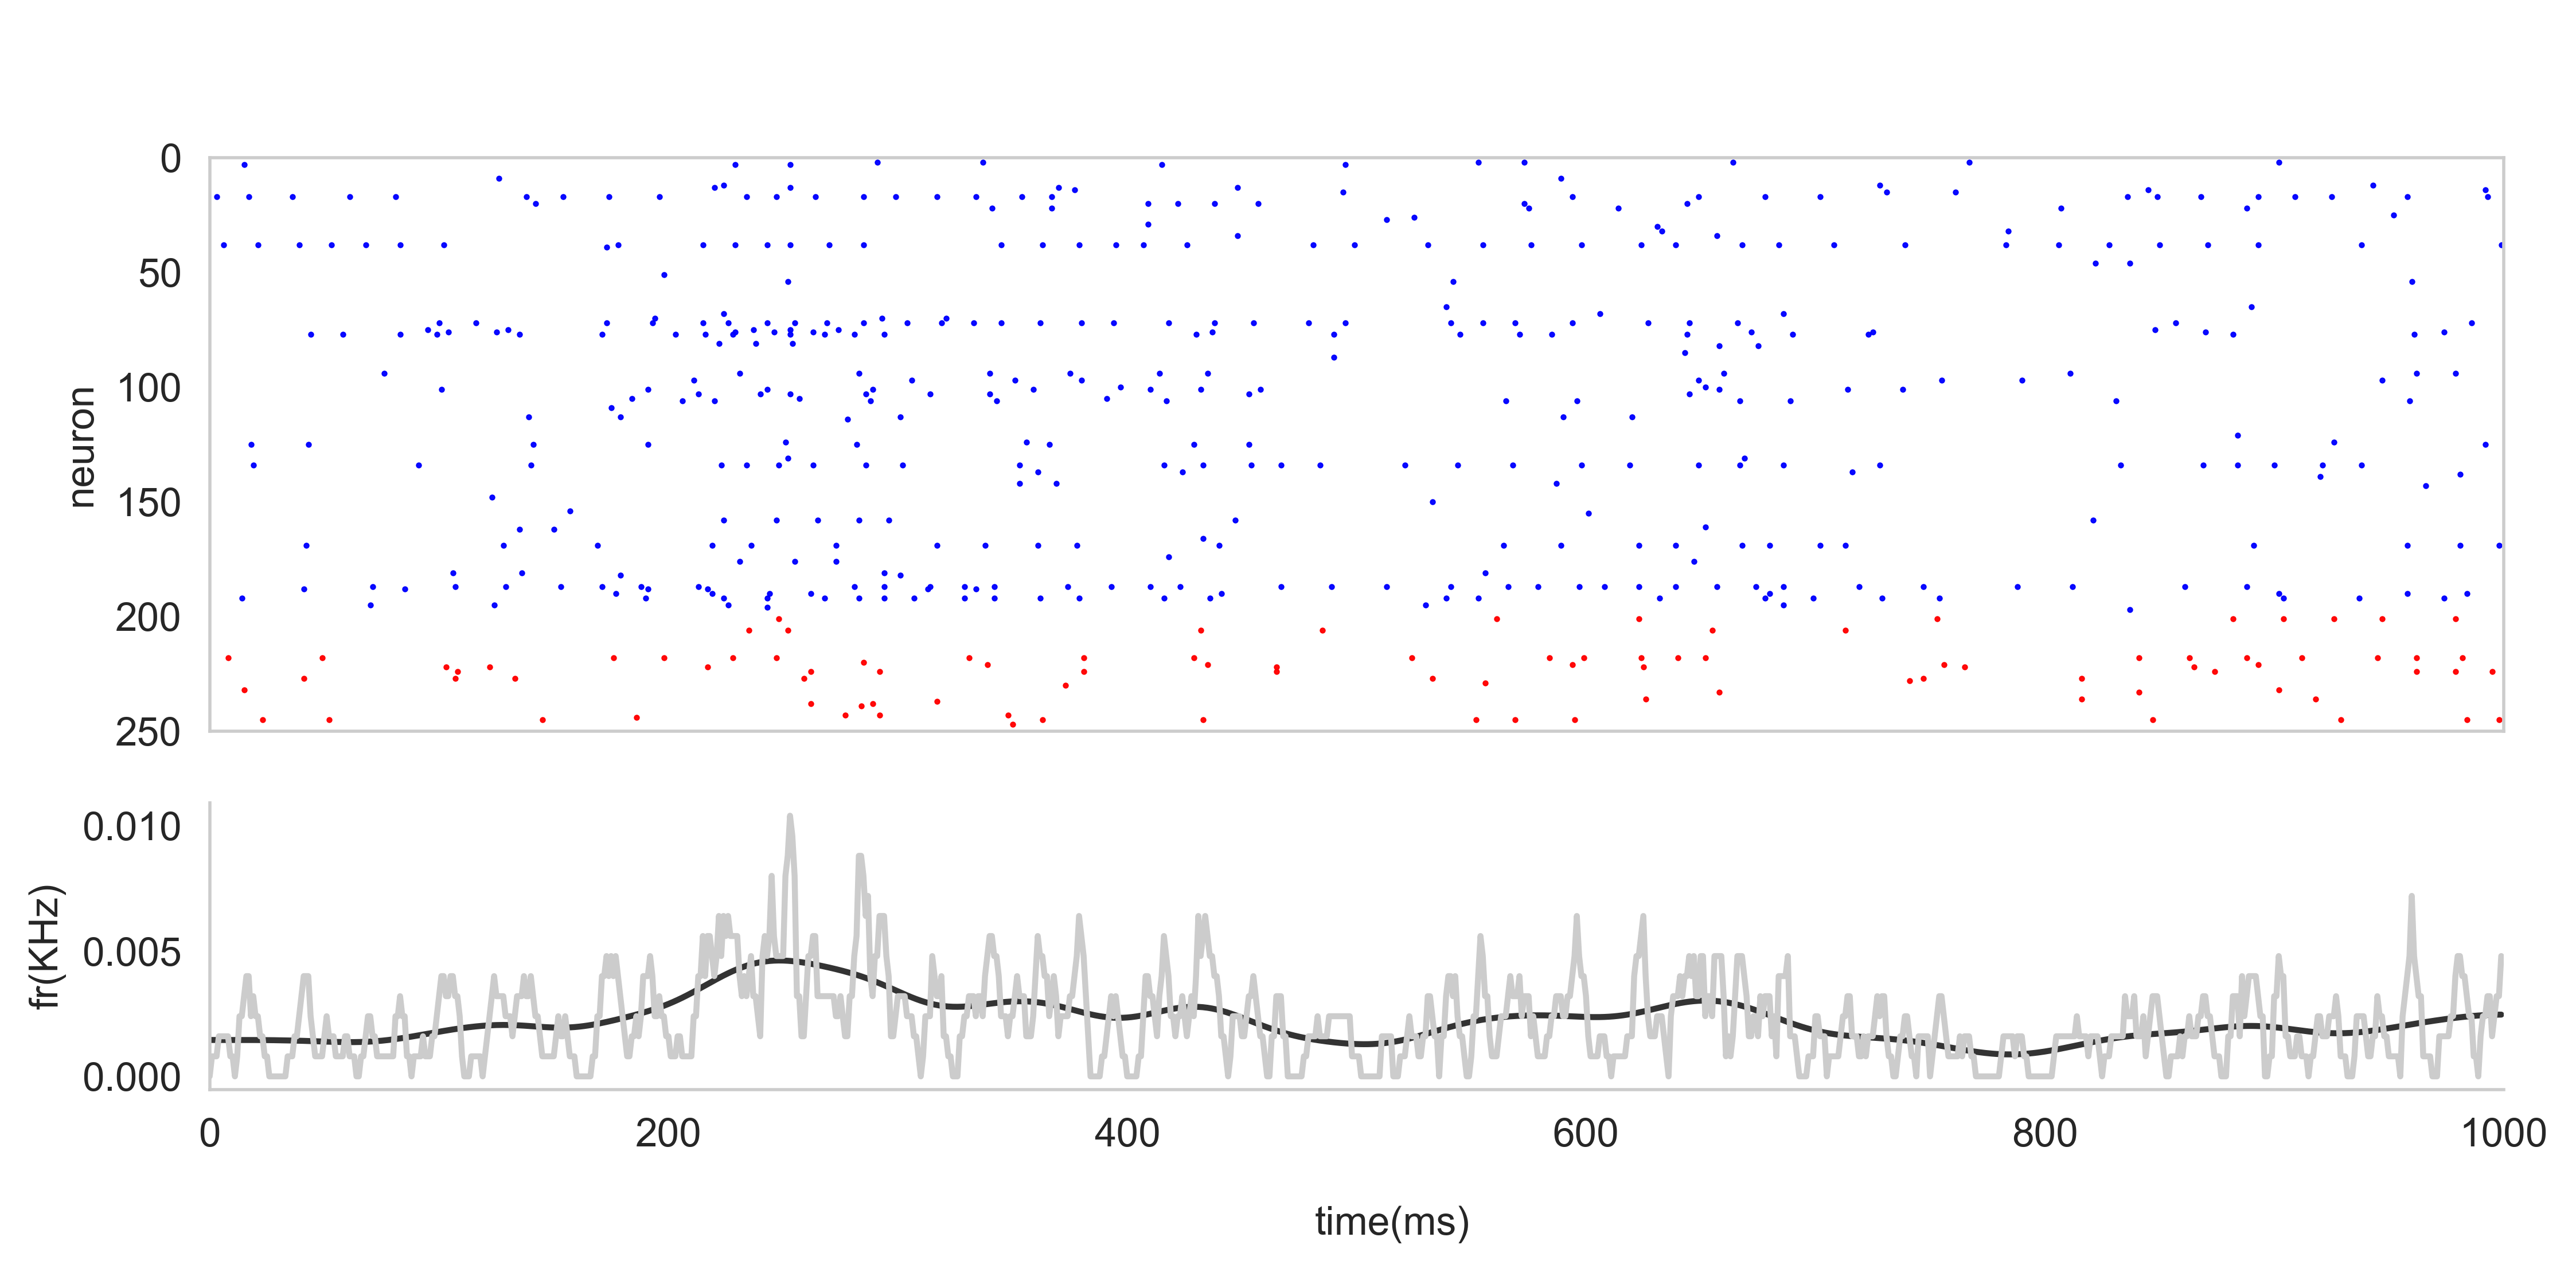

In [10]:
path = "small_block_d100_tau2_different_w"
property, w_uij = connect_for_block(os.path.join(path, 'single'))
property[:, 10:14] = torch.tensor([0.00618016, 0.00086915, 0.05027743, 0.00253291])

property = property.cuda()
w_uij = w_uij.cuda()
B = block(
    node_property=property,
    w_uij=w_uij,
    delta_t=1,
)
log_all = []
for time in range(3000):
    print(time, end='\r')
    B.run(noise_rate=0.016, isolated=False)
    if time >= 1000:
        log_all.append(B.active.data.cpu().numpy())
log_all = np.array(log_all, dtype=np.uint8)
log = log_all[:, 1400:1650]
sub_log = log[-1000:]
print("log.max", sub_log.max())
pcc_log = pearson_cc(sub_log[:, :200], pairs=200)
cc_log = correlation_coefficent(sub_log[:, :200])
mean_fr = mean_firing_rate(sub_log[:, :200])
print("mean_fr", mean_fr)
print("cc: ", cc_log)
print("pcc: ", pcc_log)
fr = instantaneous_rate(sub_log, bin_width=5)
rate_time_series_auto_kernel = gaussian_filter1d(fr, 20, axis=-1)
fig = plt.figure(figsize=(10, 5), dpi=500)
ax = fig.add_subplot(1, 1, 1, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_xlabel('time(ms)')
ax = fig.add_axes([0.1, 0.35, 0.8, 0.5])
ax.grid(False)
x, y = sub_log[:, :200].nonzero()
ax.scatter(x, y, marker='.', color="blue", s=1)
x, y = sub_log[:, 200:].nonzero()
ax.scatter(x, y + 200, marker='.', color="red", s=1)
ax.set_xlim([0, 1000])
ax.set_ylim([0, 250])
ax.set_xticks([])
ax.set_ylabel('neuron')
ax.invert_yaxis()
ax.set_aspect(1)
ax = fig.add_axes([0.1, 0.15, 0.8, 0.2])
ax.grid(False)
ax.plot(rate_time_series_auto_kernel, color='0.2')
ax.set_xlim([0, 1000])
ax.plot(fr, color='0.8')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylabel("fr(KHz)")
torch.cuda.empty_cache()
fig.savefig("raster.pdf")

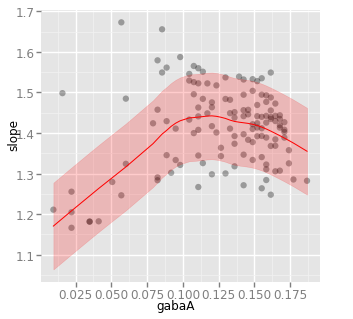

In [30]:
import pandas as pd
from ggplot import *
# TODO: 省略掉那些非临界态 即 ks<0.1的点
file = np.load('../data/along_critical_line.npz')
ks_size = file['ks_size']
slop_size = file['exponent_size']
peak_freq = file['peak_power']
cc = file['cc']
index = np.where(ks_size<0.3)
gabaA_here = gabaA_contribution[critical_index[1][:130]]
df = pd.DataFrame({"gabaA": gabaA_here, "ks": ks_size, "slope": slop_size})
p = ggplot(aes(x='gabaA', y='slope'), data=df) + \
geom_point(stat = 'sum', alpha = 0.33, size=40)  + \
stat_smooth(color='red', method="glm", se=True)
p.save("along_critical_slope.png", width=5, height=5, dpi=100)

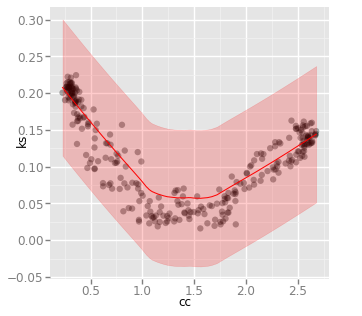

In [30]:
file1 = np.load('../data/along_vertical_line.npz')
file2 = np.load('../data/along_critical_line.npz')
ks_size1 = file1['ks_size']
cc1 = file1['cc']
ks_size2 = file2['ks_size']
cc2 = file2['cc']
cc = np.concatenate([cc1, cc2])
ks_size = np.concatenate([ks_size1, ks_size2])

df = pd.DataFrame({"cc": cc, "ks": ks_size,})
p = ggplot(aes(x='cc', y='ks'), data=df) + \
geom_point(alpha = 0.33, size=40)  + \
stat_smooth(color="red", method="loess")
p.save("cc_vc_ks.png", width=5, height=5, dpi=100)

# avalanches 统计

cc:  0.5235978
pcc:  0.05933967892003825


Text(0.5, 0, 'freqs')

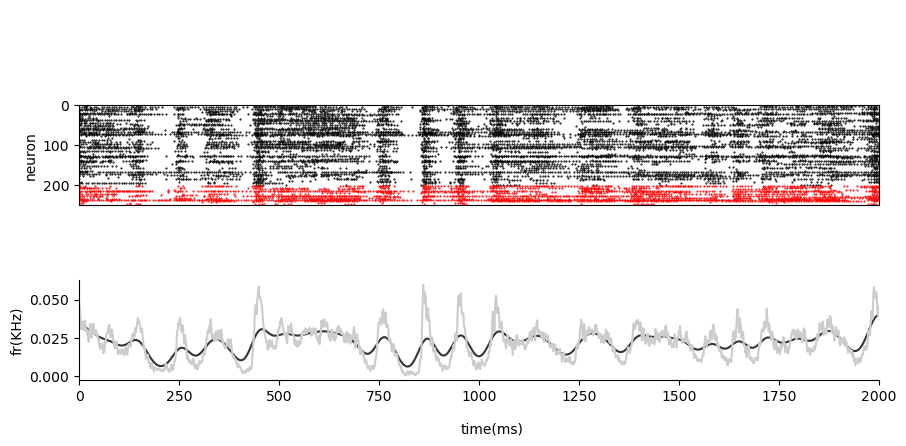

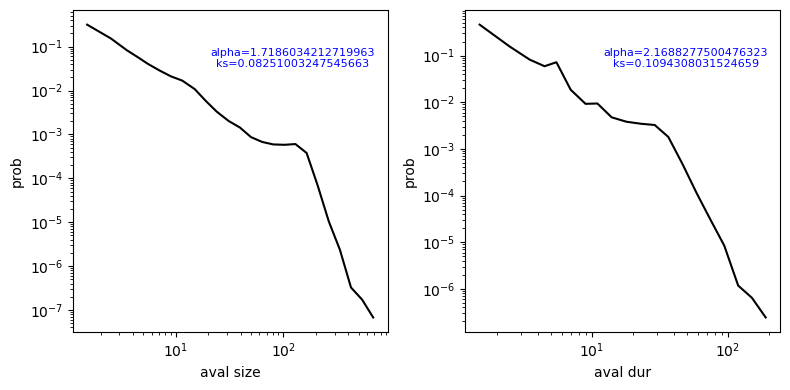

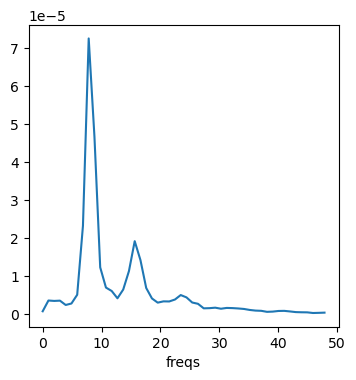

In [31]:
from analysis.avalanches import compute_avalanche
import powerlaw
def total_avalanches(spike, threshold=1):
    aval_size_total = []
    aval_dur_total = []
    for i in range(40):
        seed = np.random.randint(low=0, high=500, size=(100), dtype=np.int32)
        _, aval_size, aval_dur, _ = compute_avalanche(spike[:, seed], threshold)
        aval_size_total.append(aval_size)
        aval_dur_total.append(aval_dur)
    aval_size_total = np.concatenate(aval_size_total, axis=0)
    aval_dur_total = np.concatenate(aval_dur_total, axis=0)
    return aval_size_total, aval_dur_total

# critical parameter for d100
# np.array([0.01782278, 0.00083544, 0.09493671, 0.02250352])
spike_critical = np.load('../data/spike_vertify_cuda_noie4.npy')
spike_critical = np.reshape(spike_critical, (-1, spike_critical.shape[-1]))
spike_critical = spike_critical[20000:]
sub_log = spike_critical[-2000:, ]

pcc_log = pearson_cc(sub_log[:, :200], pairs=200)
cc_log = correlation_coefficent(sub_log[:, :200])
print("cc: ", cc_log)
print("pcc: ", pcc_log)
fr = instantaneous_rate(sub_log, bin_width=5)
rate_time_series_auto_kernel = gaussian_filter1d(fr, 20, axis=-1)
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_xlabel('time(ms)')
ax = fig.add_axes([0.1, 0.35, 0.8, 0.5])
x, y = sub_log[:, :200].nonzero()
ax.scatter(x, y, marker='.', color="black", s=1)
x, y = sub_log[:, 200:].nonzero()
ax.scatter(x, y + 200, marker='.', color="red", s=1)
ax.set_xlim([0, 2000])
ax.set_ylim([0, 250])
ax.set_xticks([])
ax.set_ylabel('neuron')
ax.invert_yaxis()
ax.set_aspect(1)
ax = fig.add_axes([0.1, 0.15, 0.8, 0.2])
ax.plot(rate_time_series_auto_kernel, color='0.2')
ax.set_xlim([0, 2000])
ax.plot(fr, color='0.8')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylabel("fr(KHz)")

aval_size, aval_dur = total_avalanches(spike_critical, threshold=1)
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_subplot(1, 2, 1)
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max(), discrete=False)
fit.plot_pdf(ax=ax, original_data=True, color="k", lw=1.5)
info = f"alpha={fit.alpha}\nks={fit.D}"
ax.text(0.7, 0.85, info, fontsize=8, ha='center', va='center', color='b',
        transform=ax.transAxes)
ax.set_xlabel("aval size")
ax.set_ylabel("prob")
ax = fig.add_subplot(1, 2, 2)
fit = powerlaw.Fit(aval_dur, xmin=aval_dur.min(), xmax=aval_dur.max(), discrete=False)
fit.plot_pdf(ax=ax, original_data=True, color="k", lw=1.5)
info = f"alpha={fit.alpha}\nks={fit.D}"
ax.text(0.7, 0.85, info, fontsize=8, ha='center', va='center', color='b',
        transform=ax.transAxes)
ax.set_xlabel("aval dur")
ax.set_ylabel("prob")
fig.tight_layout()

ins_fr = instantaneous_rate(spike_critical)
freqs, psd = welch(ins_fr, 1000, return_onesided=True, scaling='density', nperseg=1024, noverlap=800)
fig = plt.figure(figsize=(4, 4), dpi=100)
valid_freqs = freqs[:50]
valid_psd = psd[:50]
fig.gca().plot(valid_freqs, valid_psd)
fig.gca().set_xlabel("freqs")

# 模拟的尺度对临界态的性态影响
## 结论就是，模拟尺度对网络临界态基本不影响。不仅如此，不仅仅对临界态，对于相位图上的其他性态也仍然保持。

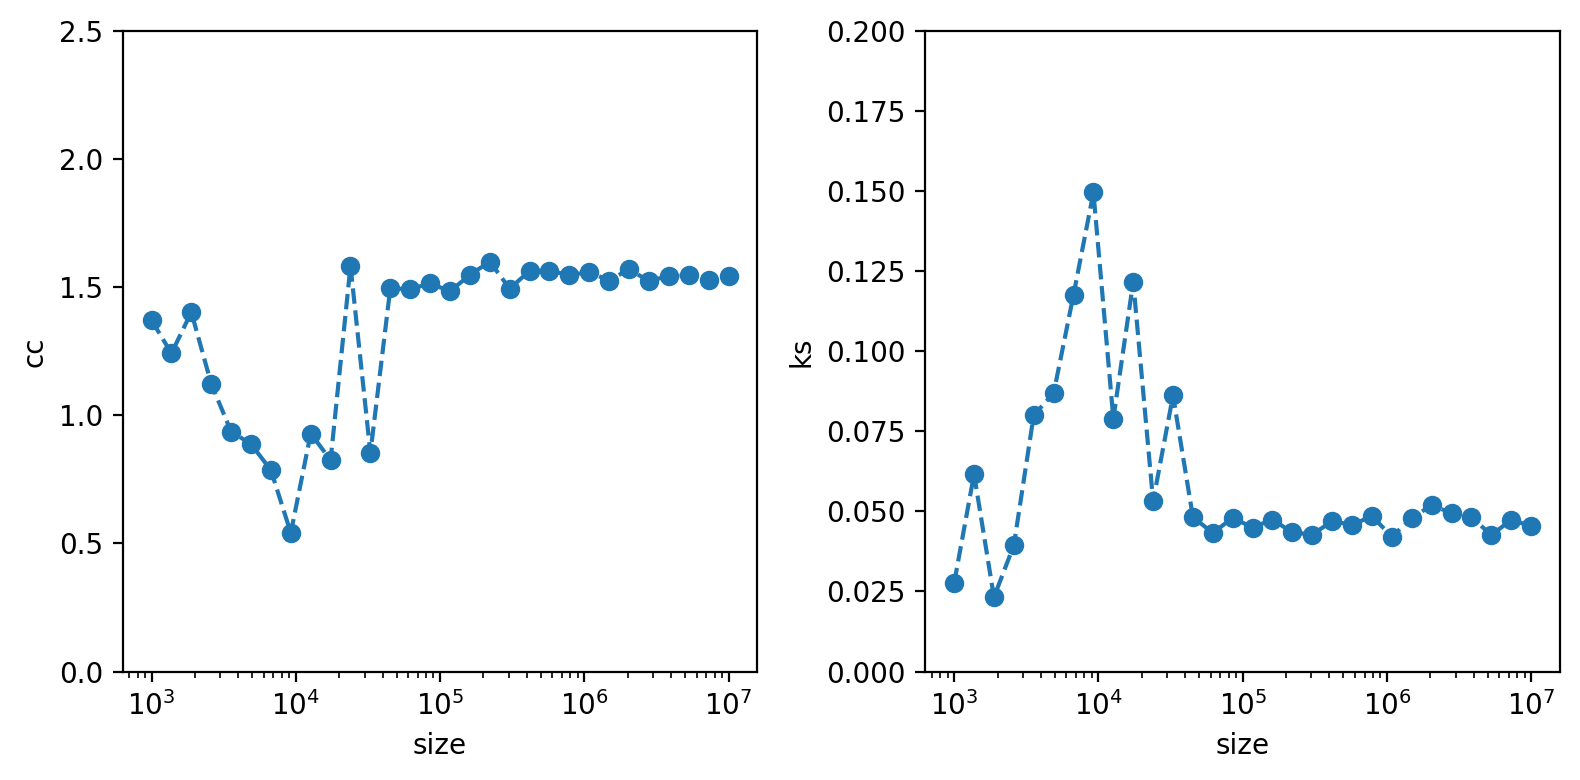

In [41]:
file = np.load("../data/size_influence_from_critical.npz")
size_list = np.logspace(3, 7, num=30, endpoint=True)
cc = file['cc']
ks = file['ks_size']
cc = cc.mean(axis=1)
ks = ks.mean(axis=1)
fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.add_subplot(1, 2, 1)
# for i in range(len(cc)):
#     ax.scatter(cc[i], ks[i], marker='o', s=100 + 20 * i, c="royalblue", alpha=0.8)
# ax.set_xlabel("cc")
# ax.set_ylabel("ks")
# ax.set_ylim([0, 0.3])
# ax.set_xlim([0, 2.5])
ax.plot(size_list, cc, "o--")
ax.set_xscale("log")
ax.set_ylim([0, 2.5])
ax.set_ylabel("cc")
ax.set_xlabel("size")
ax = fig.add_subplot(1, 2, 2)
ax.plot(size_list, ks, "o--")
ax.set_xscale("log")
ax.set_ylim([0, 0.2])
ax.set_ylabel('ks')
ax.set_xlabel("size")
fig.tight_layout()
fig.savefig("../paper/fig/size_influece1.png")


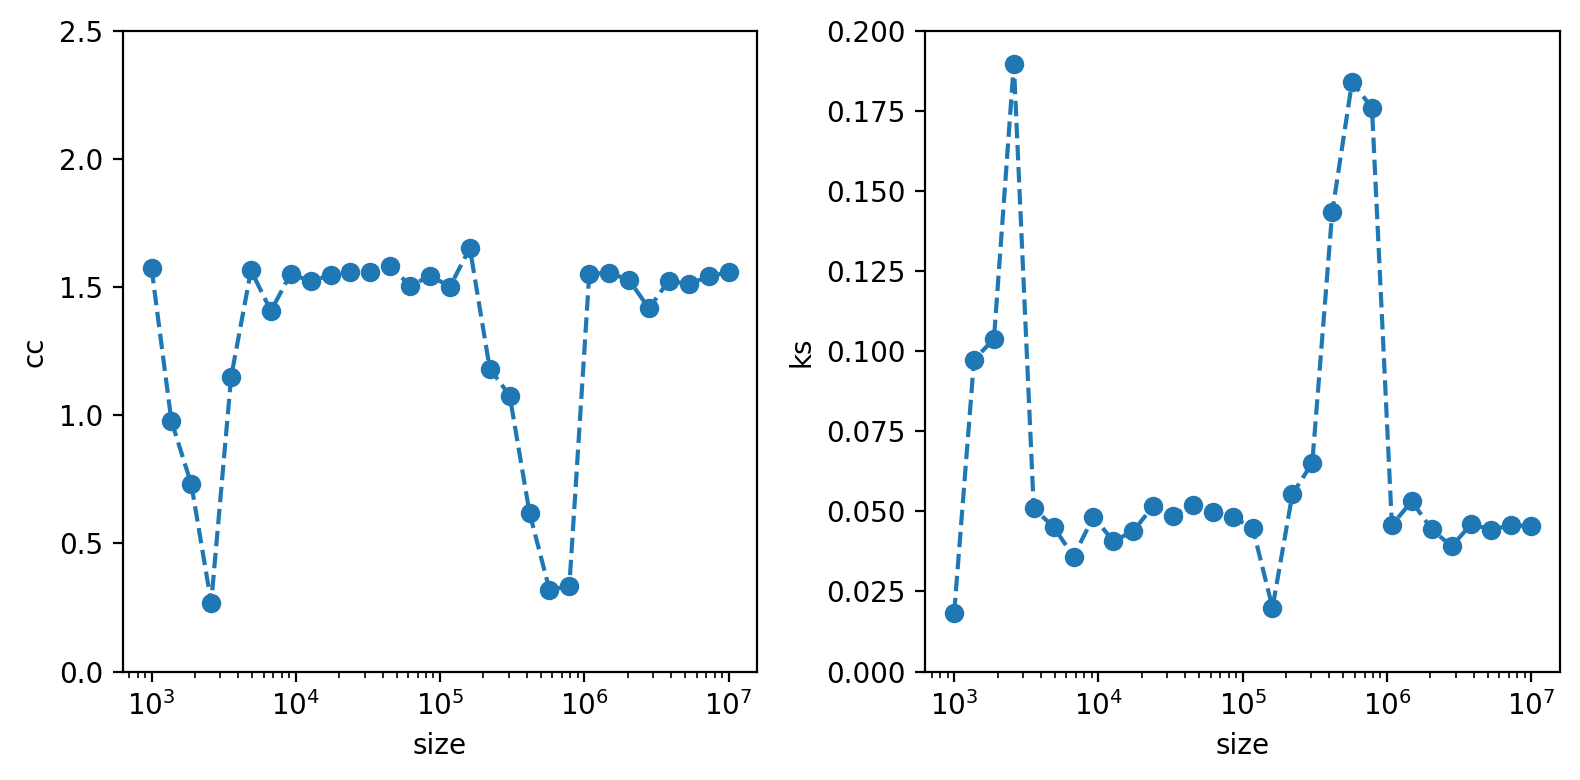

In [42]:
file = np.load("../data/size_influence_from_critical2.npz")
size_list = np.logspace(3, 7, num=30, endpoint=True)
cc = file['cc']
ks = file['ks_size']
cc = cc.mean(axis=1)
ks = ks.mean(axis=1)
fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.add_subplot(1, 2, 1)
# for i in range(len(cc)):
#     ax.scatter(cc[i], ks[i], marker='o', s=100 + 20 * i, c="royalblue", alpha=0.8)
# ax.set_xlabel("cc")
# ax.set_ylabel("ks")
# ax.set_ylim([0, 0.3])
# ax.set_xlim([0, 2.5])
ax.plot(size_list, cc, "o--")
ax.set_xscale("log")
ax.set_ylim([0, 2.5])
ax.set_ylabel("cc")
ax.set_xlabel("size")
ax = fig.add_subplot(1, 2, 2)
ax.plot(size_list, ks, "o--")
ax.set_xscale("log")
ax.set_ylim([0, 0.2])
ax.set_ylabel('ks')
ax.set_xlabel("size")
fig.tight_layout()
fig.savefig("../paper/fig/size_influece2.png")

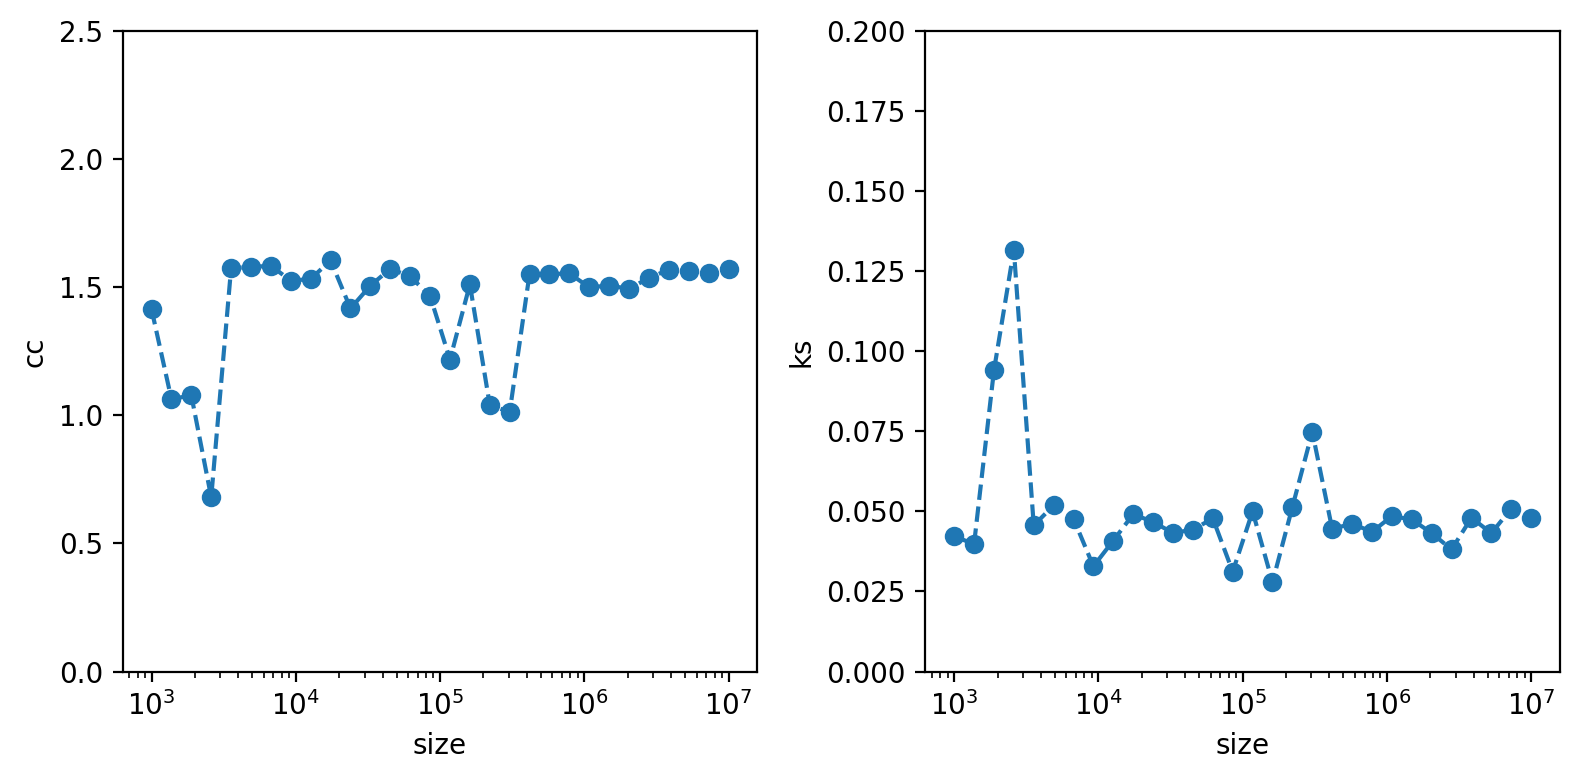

In [43]:
file = np.load("../data/size_influence_from_critical_new.npz")
size_list = np.logspace(3, 7, num=30, endpoint=True)
cc = file['cc']
ks = file['ks_size']
cc = cc.mean(axis=1)
ks = ks.mean(axis=1)
fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.add_subplot(1, 2, 1)
# for i in range(len(cc)):
#     ax.scatter(cc[i], ks[i], marker='o', s=100 + 20 * i, c="royalblue", alpha=0.8)
# ax.set_xlabel("cc")
# ax.set_ylabel("ks")
# ax.set_ylim([0, 0.3])
# ax.set_xlim([0, 2.5])
ax.plot(size_list, cc, "o--")
ax.set_xscale("log")
ax.set_ylim([0, 2.5])
ax.set_ylabel("cc")
ax.set_xlabel("size")
ax = fig.add_subplot(1, 2, 2)
ax.plot(size_list, ks, "o--")
ax.set_xscale("log")
ax.set_ylim([0, 0.2])
ax.set_ylabel('ks')
ax.set_xlabel("size")
fig.tight_layout()
fig.savefig("../paper/fig/size_influece3.png")

## 度分布对临界态的影响
## 看起来也不太影响

<AxesSubplot:xlabel='value', ylabel='Probability'>

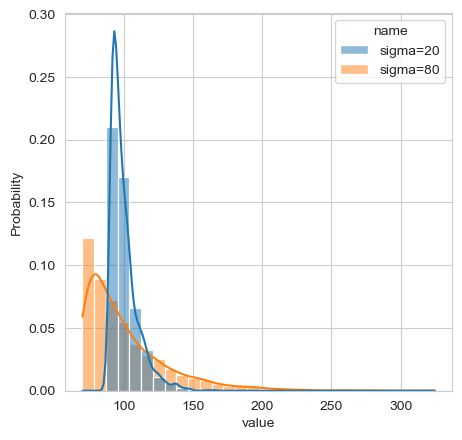

In [21]:
import seaborn as sns
import pandas as pd
def shifted_exp(sigma, size, mean=100):
    # degree = np.random.lognormal(mean=mean, sigma=sigma, size=size)
    degree = np.random.exponential(scale=sigma, size=size) + (mean - sigma)
    return degree
degree1 = shifted_exp(sigma=10, size=2000)
degree2 = shifted_exp(sigma=30, size=2000)
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.gca()
# weight = 1 / np.ones(len(degree1))
# ax.hist(degree1, bins=30, rwidth=0.8, range=(0, 500), weights=weight)
# ax.hist(degree2, bins=30, rwidth=0.8, range=(0, 500), weights=weight, alpha=0.5)
df = pd.concat(axis=0, ignore_index=True, objs=[
pd.DataFrame.from_dict({'value': degree1.flatten(), 'name': 'sigma=20'}),
pd.DataFrame.from_dict({'value': degree2.flatten(), 'name': 'sigma=80'})
])
sns.histplot(data=df, x="value", hue="name", multiple="layer", kde=True, bins=30, stat="probability",
             ax=ax)  # "layer", "stack", "fill", "dodge"

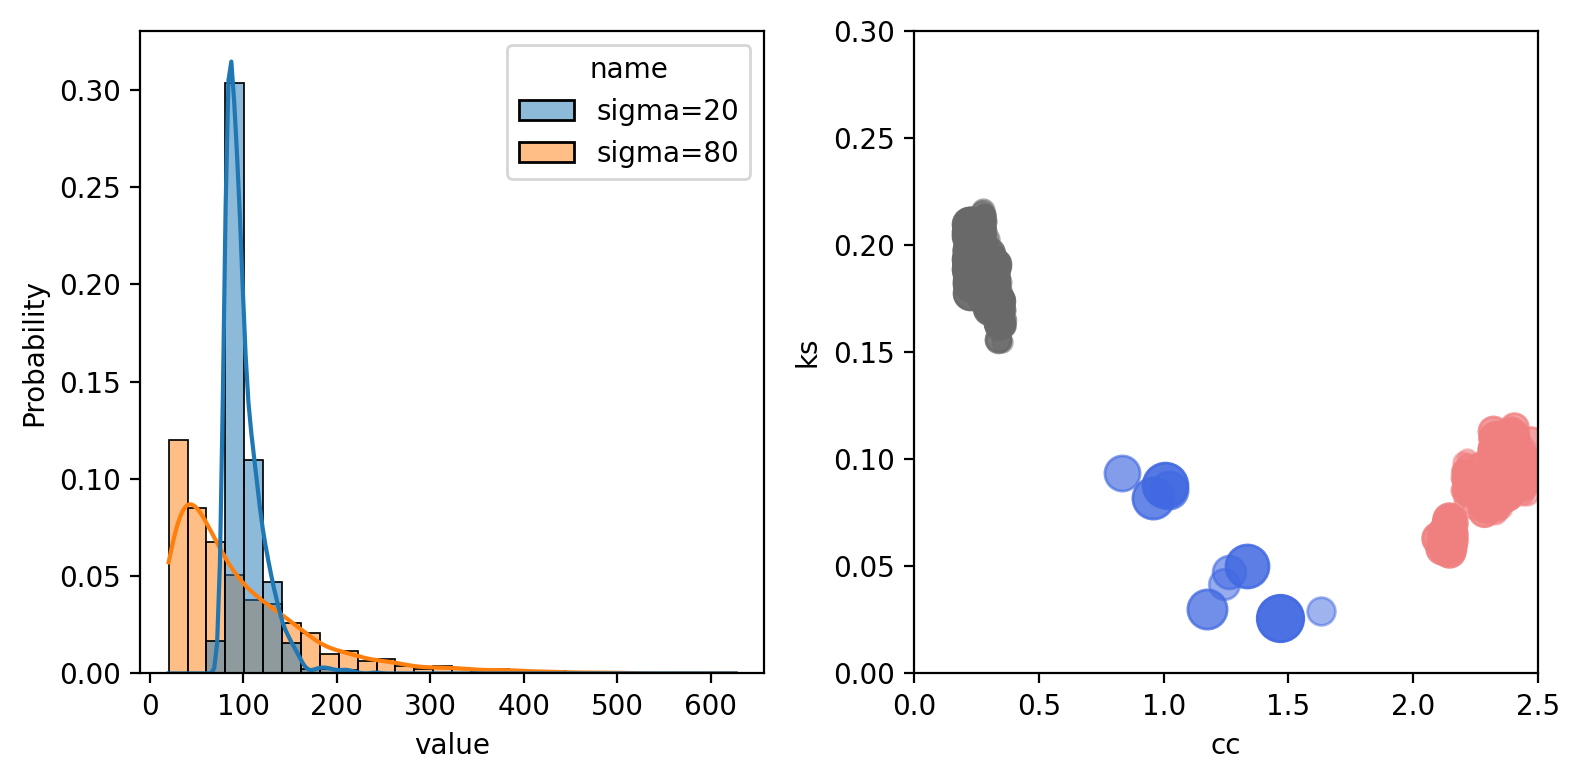

In [68]:
import pandas as pd
import seaborn as sns
file = np.load('../data/degree_influence_from_critical_new.npz')
sigma_list = np.arange(1, 30, 3)
cc = file['cc']
ks = file['ks_size']
fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.add_subplot(1, 2, 2)
cc = cc.mean(axis=1)
ks = ks.mean(axis=1)
for i in range(len(cc)):
    ax.scatter(cc[i], ks[i], marker='o', s=100 + 20 * i, c="royalblue", alpha=0.5+i*0.05)
file = np.load('../data/degree_influence_from_supcritical.npz')
cc = file['cc']
ks = file['ks_size']
for i in range(len(cc)):
    ax.scatter(cc[i], ks[i], marker='o', s=50 + 10 * i, c="lightcoral", alpha=0.5+i*0.05)
file = np.load('../data/degree_influence_from_subcritical.npz')
cc = file['cc']
ks = file['ks_size']
for i in range(len(cc)):
    ax.scatter(cc[i], ks[i], marker='o', s=50 + 10 * i, c="dimgrey", alpha=0.5+i*0.05)
ax.set_xlabel("cc")
ax.set_ylabel("ks")
ax.set_ylim([0, 0.3])
ax.set_xlim([0, 2.5])
ax = fig.add_subplot(1, 2, 1)
def shifted_exp(sigma, size, mean=100):
    degree = np.random.exponential(scale=sigma, size=size) + (mean - sigma)
    return degree
degree1 = shifted_exp(sigma=20, size=2000)
degree2 = shifted_exp(sigma=80, size=2000)

df = pd.concat(axis=0, ignore_index=True, objs=[
pd.DataFrame.from_dict({'value': degree1.flatten(), 'name': 'sigma=20'}),
pd.DataFrame.from_dict({'value': degree2.flatten(), 'name': 'sigma=80'})
])
sns.histplot(data=df, x="value", hue="name", multiple="layer", kde=True, bins=30, stat="probability",
             ax=ax)  # "layer", "stack", "fill", "dodge"
fig.tight_layout()
fig.savefig("../paper/fig/degree_influence.png")

# 参数重采样对临界态的影响

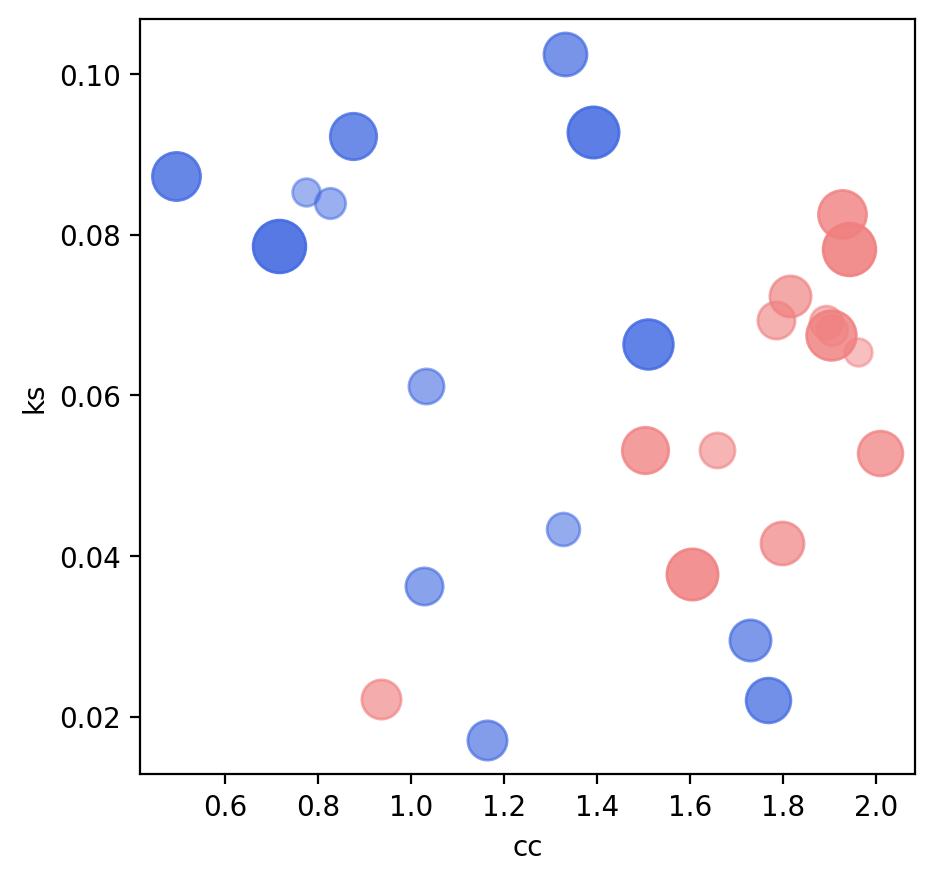

In [77]:
file = np.load('../data/reparameter_influence.npz')
raidus = np.arange(1, 15, 1)
cc = file['cc']
ks = file['ks_size']
fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(1, 1, 1)
for i in range(len(cc)):
    ax.scatter(cc[i], ks[i], marker='o', s=100 + 20 * i, c="lightcoral", alpha=0.5+i*0.03)
file = np.load('../data/reparameter_influence_along_line.npz')
cc = file['cc']
ks = file['ks_size']
for i in range(len(cc)):
    ax.scatter(cc[i], ks[i], marker='o', s=100 + 20 * i, c="royalblue", alpha=0.5+i*0.03)
ax.set_xlabel("cc")
ax.set_ylabel("ks")
fig.savefig("../paper/fig/reparameter.png")

## 度规模的影响，为了锁定发放率，按$O(1 / log(k))$ 缩放

In [12]:
np.log(500) / np.log(100)


1.3494850021680092